# Define and train the network model

In [1]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
# import tensorflow_addons as tfa
import json
import numpy as np
import matplotlib.pyplot as plt

# Load utility functions for preparing dataset
from utils.preparedata import prepare_dataset

Set random seeds

In [2]:
np.random.seed(10)
tf.random.set_seed(20)

Set all main parameters

In [3]:
n_data = 100
img_w = img_h = 256
validation_split = 0.2
batch_size = 18
kernel = 3
n_epochs = 50
lr = 0.001
model_file = './model.json'
out_checkpoint_path = './checkpoint'
out_weights_file = './model_weights_final_eps' + str(n_epochs) + '.hdf5'

Define the encoder

In [ ]:
encoding_layers = [
    Convolution2D(filters=64, kernel_size=kernel, padding='same',
                  input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=64, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Convolution2D(filters=128, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=128, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Convolution2D(filters=256, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=256, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=256, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

Define the decoder

In [ ]:
decoding_layers = [
    UpSampling2D(),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=512, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=256, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Convolution2D(filters=256, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=256, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=128, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Convolution2D(filters=128, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=64, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Convolution2D(filters=64, kernel_size=kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(filters=n_labels, kernel_size=1, padding='valid'),
    BatchNormalization(),
]

Build the full auto-encoder: encoder layers + decoder layers + output (softmax) layer

In [ ]:
autoencoder = models.Sequential()

# Add all encoding layers
autoencoder.encoding_layers = encoding_layers
for l in autoencoder.encoding_layers:
    autoencoder.add(l)
    print(l.input_shape, l.output_shape, l)

# Add all decoding layers
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

# Add output layer
autoencoder.add(Activation('softmax'))

# View a summary of the full network
autoencoder.summary()

Save the model structure to file

In [ ]:
with open(model_file, 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))

Define custom functions for (i) loading the data, (ii) converting it to a conveninent data-type, (iii) splitting the 2000x2000 array in 64 slightly overlapping 256x256 patches, and (iv) one-hot encoding the target binary map

Load the whole data

In [4]:
data, labels, weights = prepare_dataset(n=n_data, img_h=img_h, img_w=img_w,
                                        max_val=130., max_weight=4., verbose=True)

All training data has been loaded from ./data/train
	shapes: (6400, 256, 256, 1), (6400, 256, 256, 2), (6400, 256, 256, 1)
	types:  uint8, bool, uint8
	memory: 400.0, 800.0, 400.0 MB
	tot memory:  1.5625 GB


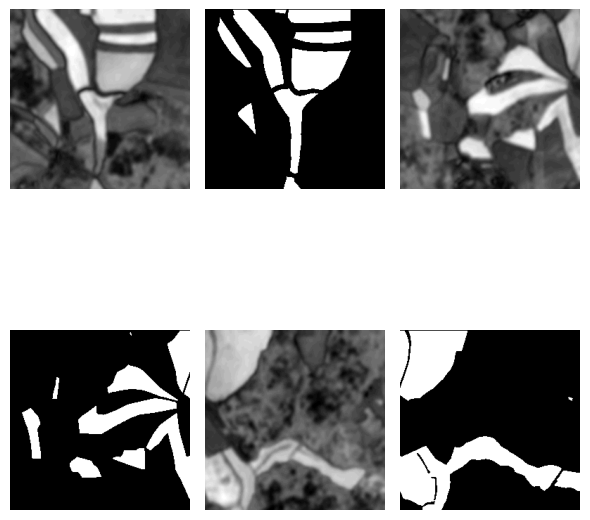

In [5]:
n_show_samples = 3
plt.figure(figsize=(2 * n_show_samples, 8))
for k in range(n_show_samples):
    plt.subplot(2, n_show_samples, 2 * k + 1)
    plt.ylabel('Sample ' + str(k+1))
    plt.xlabel('Data')
    plt.imshow(data[k], cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, n_show_samples, 2 * k + 2)
    plt.xlabel('Label')
    plt.imshow(labels[k, ..., 1], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Split training and test data

In [6]:
train_X, test_X, train_y, test_y, train_w, test_w = train_test_split(data, labels, weights,
                                                                     test_size=validation_split,
                                                                     shuffle=True,
                                                                     random_state=20)
# Define number of samples in each set
n = data.shape[0]
n_train = train_X.shape[0]
n_test = test_X.shape[0]

# Take 6 random data samples, just for visualizing some final predictions
n_predict = 6
ids_predict = np.random.randint(0, n, size=n_predict)
X_predict = np.copy(data[ids_predict])
y_predict = np.copy(labels[ids_predict])
w_predict = np.copy(weights[ids_predict])
del data, labels, weights

# Define the 2 sets as tensorflow data objects and split it in batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y, train_w))
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y, test_w))
train_dataset = train_dataset.shuffle(100).batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
del train_X, test_X, train_y, test_y, train_w, test_w

Set final parameters for training the model

In [7]:
steps_per_epoch = n_train // batch_size
validation_steps = n_test // batch_size

Compile the model's optimization process

In [9]:
optimizer = optimizers.Adam(learning_rate=lr)
# optimizer = optimmizers.SGD(learning_rate=lr, momentum=0.9, decay=0.0005, nesterov=False)

# loss = "mean_squared_error"
loss = "categorical_crossentropy"
# loss = tf.keras.losses.SparseCategoricalCrossentropy()

metrics = "accuracy"
# metrics = functional.matthews_correlation  # from utils import functional
# metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)

autoencoder.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

Train and store the final model weights and some training checkpoints

In [10]:
callback = ModelCheckpoint(
    filepath=out_checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch')

history = autoencoder.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[callback],
    verbose=True)

autoencoder.save_weights(out_weights_file)

Epoch 1/50
284/284 [==============================] - 316s 830ms/step - loss: 9.9377 - accuracy: 0.8197 - val_loss: 7.9390 - val_accuracy: 0.8581
Epoch 2/50
284/284 [==============================] - 243s 855ms/step - loss: 7.1403 - accuracy: 0.8634 - val_loss: 8.3358 - val_accuracy: 0.8625
Epoch 3/50
284/284 [==============================] - 253s 891ms/step - loss: 6.5028 - accuracy: 0.8722 - val_loss: 9.7059 - val_accuracy: 0.8047
Epoch 4/50
284/284 [==============================] - 251s 885ms/step - loss: 6.1276 - accuracy: 0.8791 - val_loss: 5.2546 - val_accuracy: 0.8996
Epoch 5/50
284/284 [==============================] - 236s 832ms/step - loss: 5.7290 - accuracy: 0.8858 - val_loss: 8.2972 - val_accuracy: 0.8140
Epoch 6/50
284/284 [==============================] - 250s 880ms/step - loss: 5.4865 - accuracy: 0.8919 - val_loss: 10.1874 - val_accuracy: 0.8324
Epoch 7/50
284/284 [==============================] - 251s 883ms/step - loss: 5.3775 - accuracy: 0.8928 - val_loss: 5.3172 

Evaluate performance

In [11]:
score = autoencoder.evaluate(test_dataset, verbose=False)

print('\nPerformance:')
print('Test score:', score[0])
print('Test accuracy:', score[1])


Performance:
Test score: 4.786930561065674
Test accuracy: 0.9141433238983154


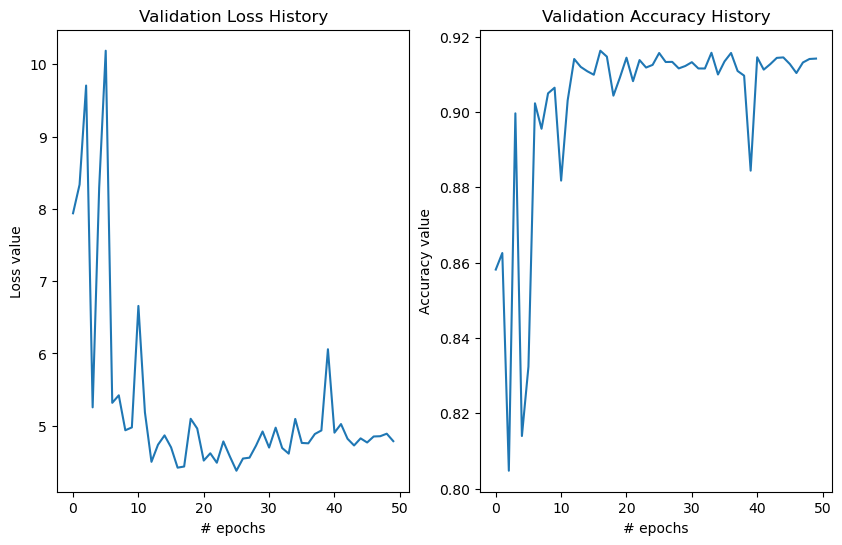

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss History')
plt.xlabel('# epochs')
plt.ylabel('Loss value')
plt.subplot(122)
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy History')
plt.xlabel('# epochs')
plt.ylabel('Accuracy value')
plt.show()

Make some predictions

In [13]:
outputs = autoencoder.predict(X_predict, verbose=False)
predictions = np.argmax(outputs[:n_predict], axis=-1).astype(bool)

Compute the Mattews correlation coefficient on the predicted samples

In [14]:
mcc = matthews_corrcoef(y_predict[..., 1].ravel(), predictions.ravel(), sample_weight=w_predict.ravel())
print('Matthews correlation coefficient on test data is', mcc)

Matthews correlation coefficient on test data is 0.849433379523692


View the predictions

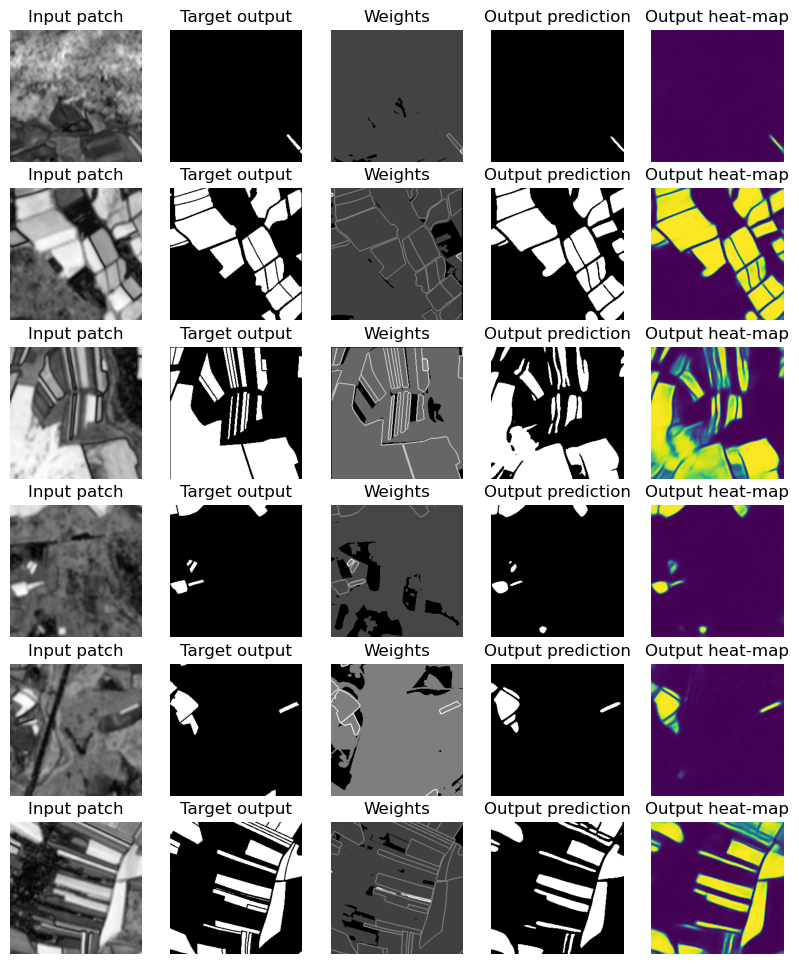

In [15]:
plt.figure(figsize=(10, 2 * n_predict))
for k in range(n_predict):
    inp = X_predict[k, :, :, 0]
    lbl = y_predict[k, :, :, 1]
    wht = w_predict[k, :, :, 0]
    out = outputs[k, :, :, 1]
    pred = predictions[k]

    plt.subplot(n_predict, 5, 5 * k + 1)
    plt.title('Input patch')
    plt.axis('off')
    plt.imshow(inp, cmap='gray')

    plt.subplot(n_predict, 5, 5 * k + 2)
    plt.title('Target output')
    plt.axis('off')
    plt.imshow(lbl, cmap='gray')

    plt.subplot(n_predict, 5, 5 * k + 3)
    plt.title('Weights')
    plt.axis('off')
    plt.imshow(wht, cmap='gray')

    plt.subplot(n_predict, 5, 5 * k + 4)
    plt.title('Output prediction')
    plt.axis('off')
    plt.imshow(pred, cmap='gray')

    plt.subplot(n_predict, 5, 5 * k + 5)
    plt.title('Output heat-map')
    plt.axis('off')
    plt.imshow(out)
plt.show()